In [1]:
!pip install scProject -U
import random
random.seed(a=613)
import numpy as np
import scProject
import scanpy as sc

dataset = sc.read('/home/abaraban/conda_env/humanRetinaData/humanRetinaDataset.h5ad')
dnorm = np.linalg.norm(dataset.X, axis=1, ord=1, keepdims=True)
dnormalized = dataset.X / (dnorm * .001)
dataset.X = dnormalized
patterns= sc.read('retina_patterns.h5ad')

scProject.matcher.orthologMapper(dataset, 'gene_map.csv', 'Gene stable ID','Mouse gene stable ID', 'id')
dataset_filtered, patterns_filtered = scProject.matcher.filterAnnDatas(dataset, patterns, 'id')

import matplotlib.pyplot as plt
from sklearn import linear_model
plt.rcParams['figure.figsize']= [10, 12]
dataset_filtered = scProject.matcher.logTransform(dataset_filtered)

scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'H01', .0001, .01, layer='log', iterations=100000)





Requirement already up-to-date: scProject in /home/abaraban/anaconda3/envs/scProjections/lib/python3.7/site-packages (1.0.9.8997)
(118555, 2412) dataset filter shape
(80, 2412) patterns filter shape


Trying to set attribute `.X` of view, copying.
Trying to set attribute `.X` of view, copying.


A layer named 'log' has been added to your filtered dataset
Regressing on loglayer of dataset_filtered
(118555, 80)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt  


outputs = dataset_filtered.obs['umap2_CellType']
classes = outputs.unique()
Predscores = np.zeros((80,len(classes)))
AUCScores = np.zeros((80,len(classes)))
meanPatternWeightInCellType = np.zeros((80,len(classes)))
targetCellType = []
curves = {}
for i in range(80):
    model = RandomForestClassifier(class_weight = 'balanced', n_jobs=-1) 
    pattern_weights = dataset_filtered.obsm['H01'][:,i]
    X_train, X_test, y_train, y_test = train_test_split(dataset_filtered.obsm['H01'][:,i].reshape(-1,1), dataset_filtered.obs['umap2_CellType'], test_size = 0.70, random_state=613, stratify=dataset_filtered.obs['umap2_CellType'] )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # print(predictions)
    for j in range(len(classes)):
        class_at_hand = model.classes_[j]
        indices = [] # index of all occurences of a class
        for idx in range(len(y_test)):
            if y_test[idx] == class_at_hand:
                indices.append(idx)
        # print(len(indices))
        score = 0
        for predict, truth in zip(predictions[indices], y_test[indices]):
            if predict == truth:
                score +=1
        score = score/len(indices)
        # prediction score
        Predscores[i,j] = score
        
        #ROC AUC score
        binarize = {class_at_hand: 1}
        biny_test = [binarize.get(x, 0) for x in y_test]
        # bi_predictions = [binarize.get(x,0) for x in predictions]
        bi_predictions = model.predict_proba(X_test)[:, j]
        score = roc_auc_score(biny_test, bi_predictions)
        AUCScores[i,j] = score
        
        curves[(i, class_at_hand)] = roc_curve(biny_test, bi_predictions)
        #Mean Pattern Weight
        meanPatternWeightInCellType[i,j] = np.mean(X_test[indices])
        
        print(i, class_at_hand)
        print(AUCScores[i,j], Predscores[i,j])
        print(meanPatternWeightInCellType[i,j])

0 AC/HC_Precurs
0.5061675561317849 0.012030075187969926
0.026521693915128708
0 Amacrine Cells
0.5722067479964519 0.18124517622845382
0.13523751497268677
0 BC/Photo_Precurs
0.5101899017821009 0.01904761904761905
0.03033609129488468
0 Bipolar Cells
0.70312534458393 0.26518366749597544
0.16792750358581543
0 Cones
0.48271035136642837 0.08007448789571694
0.05681883171200752
0 Horizontal Cells
0.5250583299325864 0.11542453809424953
0.14679604768753052
0 Muller Glia
0.7461195637317659 0.9142945544554455
0.0035131615586578846
0 Neurogenic Cells
0.5959117689370087 0.02369165487977369
0.013056330382823944
0 RPCs
0.7006369752401286 0.1419245283018868
0.009054137393832207
0 Retinal Ganglion Cells
0.5998556010899824 0.19142419601837674
0.14944550395011902
0 Rods
0.6145603225077138 0.07502834824240898
0.0176251083612442
1 AC/HC_Precurs
0.5215957622045906 0.015789473684210527
0.025376763194799423
1 Amacrine Cells
0.5370118369703616 0.16568047337278108
0.13411588966846466
1 BC/Photo_Precurs
0.55493880

10 BC/Photo_Precurs
0.3833277693127396 0.03529411764705882
0.2757766544818878
10 Bipolar Cells
0.6429060251494374 0.005268549685350505
0.011933640576899052
10 Cones
0.5085847010187343 0.030829712393958205
0.08742213249206543
10 Horizontal Cells
0.4686527282301354 0.09860909279634628
0.10253696888685226
10 Muller Glia
0.7163710885676629 0.994740099009901
0.0004045281675644219
10 Neurogenic Cells
0.5675954925366167 0.1562942008486563
0.42408081889152527
10 RPCs
0.507513017561943 0.12939622641509435
0.09127570688724518
10 Retinal Ganglion Cells
0.5528735857461043 0.019351245997494083
0.06358999013900757
10 Rods
0.5382307034205926 0.04485321910041577
0.05092431232333183
11 AC/HC_Precurs
0.5008267647406273 0.01804511278195489
0.2513011395931244
11 Amacrine Cells
0.5491126902638985 0.12387445330589143
0.2703734040260315
11 BC/Photo_Precurs
0.5191945360972823 0.0392156862745098
0.2729663848876953
11 Bipolar Cells
0.6591243889480801 0.1842528903848968
0.31570515036582947
11 Cones
0.52185314468

20 BC/Photo_Precurs
0.5241271214165188 0.01904761904761905
0.053928833454847336
20 Bipolar Cells
0.5945262482663718 0.18469193619200935
0.49353885650634766
20 Cones
0.554335864234224 0.1440099317194289
0.3703124523162842
20 Horizontal Cells
0.6195218079493848 0.018268631928586257
0.042338669300079346
20 Muller Glia
0.595983202753115 0.1500618811881188
0.9562714695930481
20 Neurogenic Cells
0.6256726297131832 0.010961810466760962
0.011598547920584679
20 RPCs
0.6953964234813457 0.0650188679245283
0.013861119747161865
20 Retinal Ganglion Cells
0.700647985317739 0.9138243073924545
0.00397710595279932
20 Rods
0.9253050406233526 0.7378102557641426
3.0793299674987793
21 AC/HC_Precurs
0.4946376261009127 0.02330827067669173
0.38715893030166626
21 Amacrine Cells
0.5060531228025326 0.08515564702855673
0.32479235529899597
21 BC/Photo_Precurs
0.49763739198452644 0.02969187675070028
0.3934486210346222
21 Bipolar Cells
0.5967036603069915 0.20840040977608665
0.23893389105796814
21 Cones
0.521066072929

30 RPCs
0.5848281268318393 0.2208679245283019
0.23727455735206604
30 Retinal Ganglion Cells
0.607363793277732 0.015870806069887233
0.013990070670843124
30 Rods
0.6950298597169016 0.33350132291797907
0.09602577239274979
31 AC/HC_Precurs
0.528511252598487 0.0015037593984962407
0.014367380179464817
31 Amacrine Cells
0.48885636323800763 0.0357602263956779
0.027087831869721413
31 BC/Photo_Precurs
0.548524554888701 0.0011204481792717086
0.010193935595452785
31 Bipolar Cells
0.4697077850253948 0.0636616420313186
0.04363855719566345
31 Cones
0.4534570473456203 0.04158907510862818
0.03679852932691574
31 Horizontal Cells
0.459178976694488 0.04338800083039236
0.040386248379945755
31 Muller Glia
0.493032778121713 0.10550742574257425
0.09418226778507233
31 Neurogenic Cells
0.553773190577019 0.0024752475247524753
0.008800894021987915
31 RPCs
0.5173484094582449 0.06841509433962265
0.01364635955542326
31 Retinal Ganglion Cells
0.5468826920013432 0.007796185437839343
0.010783991776406765
31 Rods
0.5440

40 Rods
0.7682198164490083 0.42950737054302635
0.29677680134773254
41 AC/HC_Precurs
0.4780384262558207 0.014285714285714285
0.04841619357466698
41 Amacrine Cells
0.5835944155012214 0.21134551067661436
0.15168911218643188
41 BC/Photo_Precurs
0.44911786299663453 0.023529411764705882
0.052106823772192
41 Bipolar Cells
0.6598416020242428 0.22669398507244257
0.16749131679534912
41 Cones
0.4894153013533433 0.06228015725222429
0.048100292682647705
41 Horizontal Cells
0.4453349549984427 0.057712269047124766
0.08125574886798859
41 Muller Glia
0.6094014145473062 0.01670792079207921
0.01780744642019272
41 Neurogenic Cells
0.5961765406278279 0.015205091937765204
0.021722590550780296
41 RPCs
0.774858389193822 0.8835094339622641
0.004389112815260887
41 Retinal Ganglion Cells
0.5080357456340858 0.06445774745927885
0.046751659363508224
41 Rods
0.5965593113037765 0.26722943177522995
0.09579738974571228
42 AC/HC_Precurs
0.5012252907216301 0.018796992481203006
0.0790071189403534
42 Amacrine Cells
0.57369

50 Retinal Ganglion Cells
0.519799519644746 0.12042322149519699
0.2212940752506256
50 Rods
0.539044169643662 0.13827642686153457
0.12657999992370605
51 AC/HC_Precurs
0.5345858446554796 0.014285714285714285
0.36103978753089905
51 Amacrine Cells
0.5848596983989349 0.11834319526627218
0.2645581066608429
51 BC/Photo_Precurs
0.5701972498767498 0.08235294117647059
0.7947656512260437
51 Bipolar Cells
0.5256774883741874 0.10654178252597687
0.618610680103302
51 Cones
0.536721323040677 0.04655493482309125
0.3129490911960602
51 Horizontal Cells
0.56925059144954 0.07079094872327174
0.25456324219703674
51 Muller Glia
0.5216770968891026 0.04795792079207921
0.2910909056663513
51 Neurogenic Cells
0.5043770513327077 0.03783592644978784
0.5709550380706787
51 RPCs
0.5347109271900323 0.3187924528301887
0.4182996153831482
51 Retinal Ganglion Cells
0.6394762137260852 0.35556174300431576
0.18753814697265625
51 Rods
0.603246500408102 0.263260677837974
0.6098881959915161
52 AC/HC_Precurs
0.5137822682203003 0.0

60 RPCs
0.5009844624951192 0.03166037735849057
0.006252753082662821
60 Retinal Ganglion Cells
0.5447732816840444 0.9636642071557845
0.001628519152291119
60 Rods
0.5123553048047459 0.06123220360337659
0.014711584895849228
61 AC/HC_Precurs
0.39407878278338304 0.029323308270676692
0.38728126883506775
61 Amacrine Cells
0.5413843158231542 0.07254952405454078
0.09392990916967392
61 BC/Photo_Precurs
0.4355195829378498 0.02072829131652661
0.1372150480747223
61 Bipolar Cells
0.6533959642038037 0.02546465681252744
0.03519776463508606
61 Cones
0.6032661885532495 0.031450444858266084
0.0502709336578846
61 Horizontal Cells
0.5953135368518371 0.03466888104629438
0.04983321949839592
61 Muller Glia
0.7026019675233821 0.7793935643564357
0.023458357900381088
61 Neurogenic Cells
0.4360344039409938 0.06188118811881188
0.3311549723148346
61 RPCs
0.7913433562119457 0.5749056603773585
0.3452894985675812
61 Retinal Ganglion Cells
0.5059996611880847 0.08715021578727551
0.12487026304006577
61 Rods
0.69780622097

70 Neurogenic Cells
0.509482992916642 0.005304101838755304
0.015470526181161404
70 RPCs
0.5762474834806711 0.17249056603773585
0.03229200467467308
70 Retinal Ganglion Cells
0.5571159557995827 0.1562021439509954
0.08469153195619583
70 Rods
0.5952202967736941 0.9848179412876402
0.0010429370449855924
71 AC/HC_Precurs
0.5252385147956654 0.002255639097744361
0.017359811812639236
71 Amacrine Cells
0.5563632114993019 0.009518909184461024
0.010852371342480183
71 BC/Photo_Precurs
0.512438369761973 0.0033613445378151263
0.02129128761589527
71 Bipolar Cells
0.5748335425892611 0.007171081516171521
0.007121517788618803
71 Cones
0.5147273402178861 0.015311400786261121
0.017486391589045525
71 Horizontal Cells
0.5296946824093927 0.013286277766244551
0.01893448457121849
71 Muller Glia
0.6096684811767974 0.9133663366336634
0.007592936512082815
71 Neurogenic Cells
0.43403191653177053 0.025813295615275813
0.04117903485894203
71 RPCs
0.5429473996774126 0.16705660377358492
0.03058084100484848
71 Retinal Gan

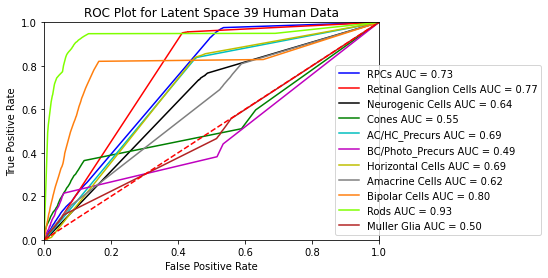

In [10]:
from sklearn import metrics
plt.title('ROC Plot for Latent Space 39 Human Data')
colors = ['b', 'r', 'k', 'g', 'c', 'm', 'y', 'tab:gray', 'tab:orange', 'chartreuse', 'firebrick']
counter = 0
for i in dataset_filtered.obs['umap2_CellType'].unique():
    fpr, tpr, threshold = curves[(38, i)]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[counter], label = i + ' AUC = %0.2f' % roc_auc)
    counter +=1
plt.legend(loc = 'lower right', bbox_to_anchor=(1.5, 0))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('latentspace39/ROCPlot.pdf')
plt.show()
    

In [ ]:
import pandas as pd
humanPredScoresdf = pd.DataFrame(Predscores, columns=model.classes_, index=["Feature " + str(x+1) for x in range(80)])
humanAUCScoresdf = pd.DataFrame(AUCScores, columns=model.classes_, index=["Feature " + str(x+1) for x in range(80)])
humanMeanPatternWeightInCellType = pd.DataFrame(meanPatternWeightInCellType, columns=model.classes_, index=["Feature " + str(x+1) for x in range(80)])

humanPredScoresdf.to_csv('lowLassohumanPredictionScores.csv')
humanAUCScoresdf.to_csv('lowLassohumanAUCScores.csv')
humanMeanPatternWeightInCellType.to_csv('lowLassohumanMeanPatternWeightInCellType.csv')

In [ ]:
mousedataset = sc.read('/home/abaraban/conda_env/mouseRetinaData/mouseRetinaDataset.h5ad')
dnorm = np.linalg.norm(mousedataset.X, axis=1, ord=1, keepdims=True)
dnormalized = mousedataset.X / (dnorm * .001)
mousedataset.X = dnormalized
varAdd = pd.read_csv('/home/abaraban/conda_env/mouseRetinaData/10x_Mouse_retina_pData_umap2_CellType_annot.csv', header=None)
mousedataset.obs['umap2_CellType'] = varAdd.drop(varAdd.index[[0]]).iloc[:,93].to_numpy()
mousepatterns= sc.read_h5ad('retina_patterns.h5ad')
mousedataset_filtered, mousepatterns_filtered = scProject.matcher.filterAnnDatas(mousedataset, mousepatterns, 'id')
mousedataset_filtered = scProject.matcher.logTransform(mousedataset_filtered)
scProject.rg.NNLR_ElasticNet(mousedataset_filtered, mousepatterns_filtered, 'mouse', .001, .01, layer='log')

outputs = mousedataset_filtered.obs['umap2_CellType']
classes = outputs.unique()
mouseAUCScores = np.zeros((80,len(classes)))
mousePredScores = np.zeros((80, len(classes)))
mouseMeanPatternWeightInCellTypes = np.zeros((80, len(classes)))


for i in range(80):
    model = RandomForestClassifier(class_weight='balanced', n_jobs=-1) 
    pattern_weights = mousedataset_filtered.obsm['mouse'][:,i]
    X_train, X_test, y_train, y_test = train_test_split(mousedataset_filtered.obsm['mouse'][:,i].reshape(-1,1), mousedataset_filtered.obs['umap2_CellType'], test_size = 0.70, random_state=613, stratify=mousedataset_filtered.obs['umap2_CellType'])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    for j in range(len(classes)):
        class_at_hand = model.classes_[j]
        indices = [] # index of all occurences of a class
        for idx in range(len(y_test)):
            if y_test[idx] == class_at_hand:
                indices.append(idx)
        # print(len(indices))
        score = 0
        for predict, truth in zip(predictions[indices], y_test[indices]):
            if predict == truth:
                score +=1
        score = score/len(indices)
        
        #Prediction Scores
        mousePredScores[i,j] = score
        
        #AUC ROC scores
        binarize = {class_at_hand: 1}
        biny_test = [binarize.get(x, 0) for x in y_test]
        # bi_predictions = [binarize.get(x,0) for x in predictions]
        bi_predictions = model.predict_proba(X_test)[:, j]
        score = roc_auc_score(biny_test, bi_predictions)
        curves[(i, class_at_hand)] = roc_curve(biny_test, bi_predictions)
        mouseAUCScores[i,j] = score

        # mean pattern weight in cell type
        mouseMeanPatternWeightInCellTypes[i,j] = np.mean(X_test[indices])
        print(i, class_at_hand)
        print(mouseAUCScores[i,j], mousePredScores[i,j])
        print(mouseMeanPatternWeightInCellTypes[i,j])


In [ ]:
import pandas as pd
mousePredScoresdf = pd.DataFrame(mousePredScores, columns=model.classes_, index=["Feature " + str(x+1) for x in range(80)])
mouseAUCScoresdf = pd.DataFrame(mouseAUCScores, columns=model.classes_, index=["Feature " + str(x+1) for x in range(80)])
mouseMeanPatternWeightdf = pd.DataFrame(mouseMeanPatternWeightInCellTypes, columns=model.classes_, index=["Feature " + str(x+1) for x in range(80)])
mousePredScoresdf.to_csv('lowLassomousepredScoresFiltered.csv')
mouseAUCScoresdf.to_csv("lowLassomouseAUCScores.csv")
mouseMeanPatternWeightdf.to_csv("lowLassomouseMeanPatternWeight.csv")